In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
import time  # Add time module for measuring execution tim

In [3]:
class GaussianMixtureModel:
    def __init__(self, n_components=3, max_iterations=10000, 
                 tolerance=1e-4, n_init=10):
        """
        Gaussian Mixture Model with EM Algorithm
        
        Parameters:
        - n_components: Number of mixture components
        - max_iterations: Maximum EM iterations
        - tolerance: Convergence threshold
        - n_init: Number of random initializations
        """
        self.n_components = n_components
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.n_init = n_init
        
        # Model parameters
        self.weights = None
        self.means = None
        self.covariances = None
        
        # Best model tracking
        self.best_weights = None
        self.best_means = None
        self.best_covariances = None
        self.best_log_likelihood = -np.inf
        
        self.log_likelihoods = []
        self.parameter_history = {
            'means': [],
            'weights': [],
            'covariances': []
        }
        
        # Time tracking
        self.timing = {
            'initialization': [],
            'e_step': [],
            'm_step': [],
            'total_fit': 0,
            'per_iteration': []
        }
    
    def manual_initialization(self, init_means, init_covariances=None, init_weights=None):
        """
        Manually initialize model parameters with user-defined values
        
        Parameters:
        -----------
        init_means : array-like of shape (n_components, n_features)
            Initial means for each component
        init_covariances : array-like or None, default=None
            Initial covariance matrices. If None, identity matrices will be used.
        init_weights : array-like or None, default=None
            Initial component weights. If None, equal weights will be used.
        """
        start_time = time.time()
        
        # Set means
        self.means = np.array(init_means)
        
        # Set weights
        if init_weights is None:
            self.weights = np.ones(self.n_components) / self.n_components
        else:
            self.weights = np.array(init_weights) / np.sum(init_weights)  # Normalize
        
        # Set covariances
        n_features = self.means.shape[1]
        if init_covariances is None:
            self.covariances = [np.eye(n_features) for _ in range(self.n_components)]
        else:
            self.covariances = init_covariances
        
        # Record initialization time
        self.timing['initialization'].append(time.time() - start_time)
        
        return self.means, self.covariances, self.weights

    def random_initialization(self, X):
        """
        Randomly initialize model parameters
        """
        start_time = time.time()
        
        n_samples, n_features = X.shape
        
        # Randomly select initial means
        random_indices = np.random.choice(
            n_samples, 
            size=self.n_components, 
            replace=False
        )
        self.means = X[random_indices]
        
        # Initialize covariances
        data_cov = np.cov(X.T)
        self.covariances = [
            data_cov + np.eye(n_features) * np.random.uniform(0.1, 1.0) 
            for _ in range(self.n_components)
        ]
        
        # Uniform mixture weights
        self.weights = np.ones(self.n_components) / self.n_components
        
        # Record initialization time
        self.timing['initialization'].append(time.time() - start_time)
        
        return self.means, self.covariances, self.weights

    def e_step(self, X):
        """
        Expectation Step: Compute responsibilities
        """
        start_time = time.time()
        
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))
        
        # Compute responsibilities for each component
        for k in range(self.n_components):
            # Multivariate normal distribution
            mvn = multivariate_normal(
                mean=self.means[k], 
                cov=self.covariances[k]
            )
            
            # Compute weighted probability
            responsibilities[:, k] = self.weights[k] * mvn.pdf(X)
        
        # Normalize responsibilities
        row_sums = responsibilities.sum(axis=1)[:, np.newaxis]
        responsibilities /= row_sums
        
        # Compute log-likelihood
        log_likelihood = np.sum(np.log(row_sums))
        
        # Record E-step time
        self.timing['e_step'].append(time.time() - start_time)
        
        return responsibilities, log_likelihood

    def m_step(self, X, responsibilities):
        """
        Maximization Step: Update model parameters
        """
        start_time = time.time()
        
        n_samples, n_features = X.shape
        
        # Compute soft cluster counts
        N_k = responsibilities.sum(axis=0)
        
        # Update weights
        self.weights = N_k / n_samples
        
        # Update means
        self.means = np.dot(responsibilities.T, X) / N_k[:, np.newaxis]
        
        # Update covariances
        self.covariances = []
        for k in range(self.n_components):
            diff = X - self.means[k]
            cov = np.dot(
                (responsibilities[:, k][:, np.newaxis] * diff).T, 
                diff
            ) / N_k[k]
            
            # Add small regularization
            cov += np.eye(n_features) * 1e-6
            self.covariances.append(cov)
        
        # Record M-step time
        self.timing['m_step'].append(time.time() - start_time)
        
        return self.weights, self.means, self.covariances

    def fit(self, X, use_random_initialization=True):
        """
        Fit Gaussian Mixture Model using EM Algorithm
        """
        total_start_time = time.time()
        
        for init in range(self.n_init):
            # Random initialization
            
            if use_random_initialization:
                self.random_initialization(X)
            
            current_log_likelihood = -np.inf
            
            # EM iterations
            for iteration in range(self.max_iterations):
                iter_start_time = time.time()
                
                # E-step
                responsibilities, log_likelihood = self.e_step(X)
                
                # Check convergence
                if abs(log_likelihood - current_log_likelihood) < self.tolerance:
                    # Record per-iteration time for the final iteration
                    self.timing['per_iteration'].append(time.time() - iter_start_time)
                    break
                
                current_log_likelihood = log_likelihood
                
                # M-step
                self.m_step(X, responsibilities)
                
                # Record per-iteration time
                self.timing['per_iteration'].append(time.time() - iter_start_time)
                
                # Update best model if needed
                if log_likelihood > self.best_log_likelihood:
                    self.best_weights = self.weights.copy()
                    self.best_means = self.means.copy()
                    self.best_covariances = self.covariances.copy()
                    self.best_log_likelihood = log_likelihood
        
        # Set best parameters
        self.weights = self.best_weights
        self.means = self.best_means
        self.covariances = self.best_covariances
        
        # Record total fitting time
        self.timing['total_fit'] = time.time() - total_start_time
        
        return self.means, self.covariances, self.weights
    
    def fit_with_convergence_tracking(self, X):
        """
        Enhanced fit method to track convergence details
        """
        # Reset tracking lists
        self.log_likelihoods = []
        self.parameter_history = {
            'means': [],
            'weights': [],
            'covariances': []
        }
        
        # Reset timing measurements
        self.timing = {
            'initialization': [],
            'e_step': [],
            'm_step': [],
            'total_fit': 0,
            'per_iteration': []
        }
        
        total_start_time = time.time()
        
        for init in range(self.n_init):
            # Random initialization
            self.random_initialization(X)
            
            current_log_likelihood = -np.inf
            
            # EM iterations
            for iteration in range(self.max_iterations):
                iter_start_time = time.time()
                
                # E-step
                responsibilities, log_likelihood = self.e_step(X)
                
                # Track log-likelihood
                self.log_likelihoods.append(log_likelihood)
                
                # Track parameter evolution
                self.parameter_history['means'].append(self.means.copy())
                self.parameter_history['weights'].append(self.weights.copy())
                self.parameter_history['covariances'].append(
                    [cov.copy() for cov in self.covariances]
                )
                
                # Check convergence
                if abs(log_likelihood - current_log_likelihood) < self.tolerance:
                    # Record time for final iteration
                    self.timing['per_iteration'].append(time.time() - iter_start_time)
                    break
                
                current_log_likelihood = log_likelihood
                
                # M-step
                self.m_step(X, responsibilities)
                
                # Record per-iteration time
                self.timing['per_iteration'].append(time.time() - iter_start_time)
        
        # Record total fit time
        self.timing['total_fit'] = time.time() - total_start_time
        
        return self

    def predict(self, X):
        """
        Predict cluster assignments
        """
        start_time = time.time()
        responsibilities, _ = self.e_step(X)
        prediction_time = time.time() - start_time
        
        # Store prediction time
        if 'prediction' not in self.timing:
            self.timing['prediction'] = []
        self.timing['prediction'].append(prediction_time)
        
        return np.argmax(responsibilities, axis=1)
        
    def print_timing_stats(self):
        """
        Print timing statistics for the GMM fitting process
        """
        print("=== GMM Timing Statistics ===")
        print(f"Total fit time: {self.timing['total_fit']:.4f} seconds")
        
        if self.timing['initialization']:
            avg_init = np.mean(self.timing['initialization'])
            print(f"Average initialization time: {avg_init:.4f} seconds")
        
        if self.timing['e_step']:
            avg_e = np.mean(self.timing['e_step'])
            print(f"Average E-step time: {avg_e:.4f} seconds")
        
        if self.timing['m_step']:
            avg_m = np.mean(self.timing['m_step'])
            print(f"Average M-step time: {avg_m:.4f} seconds")
        
        if self.timing['per_iteration']:
            avg_iter = np.mean(self.timing['per_iteration'])
            print(f"Average iteration time: {avg_iter:.4f} seconds")
            print(f"Total iterations: {len(self.timing['per_iteration'])}")
        
        if 'prediction' in self.timing and self.timing['prediction']:
            avg_pred = np.mean(self.timing['prediction'])
            print(f"Average prediction time: {avg_pred:.4f} seconds")

In [4]:
import pandas as pd
import numpy as np

def generate_synthetic_gmm_data(n_samples=3000, n_clusters=3, n_features=2, 
                               cluster_std=1.0, cluster_centers=None, 
                               weights=None, random_state=42):
    """
    Generate synthetic data for Gaussian Mixture Model with arbitrary dimensions and clusters.
    
    Parameters:
    -----------
    n_samples : int, default=3000
        Total number of data points to generate.
    
    n_clusters : int, default=3
        Number of Gaussian distributions to mix.
        
    n_features : int, default=2
        Dimensionality of the generated data.
        
    cluster_std : float or array-like, default=1.0
        Standard deviation of clusters. If float, the same value is used for all clusters and dimensions.
        If array-like of shape (n_clusters,), each cluster gets its own standard deviation.
        If array-like of shape (n_clusters, n_features), each cluster and dimension gets its own std.
    
    cluster_centers : array-like or None, default=None
        Centers of the clusters. If None, randomly generated centers are used.
        Should be of shape (n_clusters, n_features).
    
    weights : array-like or None, default=None
        Mixture weights for each cluster. If None, equal weights are used.
        Should be of shape (n_clusters,) and sum to 1.0.
    
    random_state : int, default=42
        Random seed for reproducibility.
    
    Returns:
    --------
    X : ndarray of shape (n_samples, n_features)
        Generated samples.
        
    true_labels : ndarray of shape (n_samples,)
        True cluster assignments.
    """
    # Set random seed for reproducibility
    np.random.seed(random_state)
    
    # Generate random centers if not provided
    if cluster_centers is None:
        # For higher dimensions, generate centers with sufficient separation
        cluster_centers = np.random.uniform(-5, 5, size=(n_clusters, n_features))
        
        # Ensure centers are sufficiently separated
        min_distance = np.sqrt(n_features) * 2  # Scaled by dimension
        
        # Simple algorithm to separate centers (not perfect but works for reasonable n_clusters)
        for i in range(n_clusters):
            attempts = 0
            while attempts < 100:  # Limit attempts to avoid infinite loop
                too_close = False
                for j in range(i):
                    dist = np.linalg.norm(cluster_centers[i] - cluster_centers[j])
                    if dist < min_distance:
                        too_close = True
                        cluster_centers[i] = np.random.uniform(-5, 5, size=n_features)
                        break
                
                if not too_close:
                    break
                attempts += 1
    
    # Process cluster standard deviations
    if np.isscalar(cluster_std):
        # If scalar, create covariance matrices with the given std on diagonal
        covs = [np.eye(n_features) * cluster_std**2 for _ in range(n_clusters)]
    else:
        cluster_std = np.asarray(cluster_std)
        if cluster_std.ndim == 1:
            # If 1D array, each cluster gets its own std
            covs = [np.eye(n_features) * std**2 for std in cluster_std]
        else:
            # If 2D array, create diagonal covariance matrices
            covs = [np.diag(std**2) for std in cluster_std]
    
    # Generate correlation in covariance matrices (for more realistic data)
    for i in range(n_clusters):
        # Add some correlation for more interesting clusters
        if n_features >= 2:
            corr_factor = np.random.uniform(-0.7, 0.7)
            for j in range(n_features):
                for k in range(j+1, n_features):
                    covs[i][j,k] = corr_factor * np.sqrt(covs[i][j,j] * covs[i][k,k])
                    covs[i][k,j] = covs[i][j,k]  # Keep symmetric
    
    # Use equal weights if not provided
    if weights is None:
        weights = np.ones(n_clusters) / n_clusters
    else:
        # Normalize weights to sum to 1
        weights = np.asarray(weights) / np.sum(weights)
    
    # Prepare output arrays
    X = np.zeros((n_samples, n_features))
    true_labels = np.zeros(n_samples, dtype=int)
    
    # Generate samples for each component
    for i in range(n_clusters):
        # Calculate number of samples for this component
        n = int(n_samples * weights[i])
        if i == n_clusters - 1:  # Ensure we get exactly n_samples
            n = n_samples - np.sum([int(n_samples * weights[j]) for j in range(i)])
        
        # Generate samples from this Gaussian
        component_samples = np.random.multivariate_normal(
            mean=cluster_centers[i], 
            cov=covs[i], 
            size=n
        )
        
        # Assign to appropriate section of X
        start = sum(int(n_samples * weights[j]) for j in range(i))
        end = start + n
        X[start:end] = component_samples
        true_labels[start:end] = i
    
    return X, true_labels

In [5]:
def save_dataset_csv(X, true_labels, prefix="gmm"):
    """
    Save generated dataset to CSV files that are easily readable in C++
    
    Parameters:
    -----------
    X : ndarray of shape (n_samples, n_features)
        Data points to save
    
    true_labels : ndarray of shape (n_samples,)
        Cluster assignments for each data point
        
    prefix : str, default="gmm"
        Prefix for output filenames
    """
    import os
    import pandas as pd
    
    # Create a directory to store datasets if it doesn't exist
    os.makedirs('datasets', exist_ok=True)
    
    # Generate column names based on number of features
    n_features = X.shape[1]
    if n_features == 2:
        # For backward compatibility
        column_names = ['x', 'y']
    else:
        column_names = [f'feature_{i}' for i in range(n_features)]
    
    # Save data points to CSV
    pd.DataFrame(X, columns=column_names).to_csv(f'datasets/{prefix}_data.csv', index=False)
    
    # Save labels to CSV
    pd.DataFrame({'label': true_labels}).to_csv(f'datasets/{prefix}_labels.csv', index=False)
    
    print(f"Dataset saved successfully to datasets/{prefix}_data.csv and datasets/{prefix}_labels.csv!")
    print(f"Dataset has {X.shape[0]} samples with {n_features} features across {len(np.unique(true_labels))} clusters")

In [22]:
# Fit GMM with flexible parameters
def run_gmm_experiment(n_samples=1000000, n_clusters=3, n_features=2, n_init=1, 
                      max_iterations=10000, tolerance=1e-4, prefix="gmm", means = None, stds = None, weights = None, use_custom_init = False, init_means = None, init_stds = None, init_weights = None):
    """
    Run a complete GMM experiment with configurable parameters
    
    Parameters:
    -----------
    n_samples : int, default=1000000
        Number of data points to generate
    n_clusters : int, default=3
        Number of Gaussian components to fit
    n_features : int, default=2
        Dimensionality of the data
    n_init : int, default=1
        Number of random initializations to try
    max_iterations : int, default=10000
        Maximum number of EM iterations
    tolerance : float, default=1e-4
        Convergence threshold
    prefix : str, default="gmm"
        Prefix for output filenames
    """
    # Generate data
    print(f"Generating synthetic dataset with {n_samples} samples, {n_features} features, {n_clusters} clusters...")
    if means is not None or stds is not None or weights is not None:
        X, true_labels = generate_synthetic_gmm_data(
            n_samples=n_samples, 
            n_clusters=n_clusters, 
            n_features=n_features, 
            cluster_std=stds, 
            cluster_centers=means, 
            weights=weights
        )
    else:
        X, true_labels = generate_synthetic_gmm_data(
            n_samples=n_samples, 
            n_clusters=n_clusters, 
            n_features=n_features
        )
        
    save_dataset_csv(X, true_labels, prefix=prefix)
    
    # Initialize and fit GMM
    print(f"Starting GMM fitting with {n_clusters} components...")
    gmm = GaussianMixtureModel(
        n_components=n_clusters, 
        max_iterations=max_iterations,
        tolerance=tolerance,
        n_init=n_init
    )
    
    # Using custom initialization if specified
    if use_custom_init and init_means is not None:
        print("Using custom initialization parameters")
        
        # Convert standard deviations to covariance matrices
        init_covs = None
        if init_stds is not None:
            init_stds = np.asarray(init_stds)
            if init_stds.ndim == 1:
                # If 1D array, each cluster gets its own std
                init_covs = [np.eye(n_features) * std**2 for std in init_stds]
            else:
                # If 2D array, create diagonal covariance matrices
                init_covs = [np.diag(std**2) for std in init_stds]
        
        # Call manual initialization
        gmm.manual_initialization(init_means, init_covs, init_weights)
    
    total_start = time.time()
    if(use_custom_init):
        means, covs, weights = gmm.fit(X, use_random_initialization=False)
    else:
        means, covs, weights = gmm.fit(X)
    total_runtime = time.time() - total_start
    print(f"GMM fitting completed in {total_runtime:.4f} seconds")
    
    # Print timing statistics
    gmm.print_timing_stats()
    
    # Predict clusters
    print("\nPredicting cluster assignments...")
    predict_start = time.time()
    predicted_labels = gmm.predict(X)
    predict_time = time.time() - predict_start
    print(f"Prediction completed in {predict_time:.4f} seconds")
    
    # Save results to CSV
    results_df = pd.DataFrame({
        'index': np.arange(len(predicted_labels)),
        'predicted_cluster': predicted_labels
    })
    results_df.to_csv(f'{prefix}_results_python.csv', index=False)
    print(f"Prediction results saved to {prefix}_results_python.csv")
    
    # Save GMM parameters to CSV - handle arbitrary dimensions
    component_rows = []
    for i in range(gmm.n_components):
        # Format mean vector as space-separated values
        mean_str = ' '.join([f"{val:.6f}" for val in gmm.means[i]])
        
        # Format covariance matrix as space-separated values (flattened)
        cov_flat = []
        for row in range(n_features):
            for col in range(n_features):
                cov_flat.append(f"{gmm.covariances[i][row, col]:.6f}")
        cov_str = ' '.join(cov_flat)
        
        component_rows.append({
            'Component': i,
            'Weight': gmm.weights[i],
            'Mean': mean_str,
            'Covariance': cov_str
        })
    
    params_df = pd.DataFrame(component_rows)
    params_df.to_csv(f'{prefix}_parameters_python.csv', index=False)
    print(f"Model parameters saved to {prefix}_parameters_python.csv")
    
    # Visualization for 2D data
    if n_features == 2:
        create_visualizations(X, true_labels, predicted_labels, gmm, total_runtime, prefix)
    else:
        print("Skipping visualizations for high-dimensional data (n_features > 2)")
    
    # Save timing summary to text file
    save_timing_summary(X, gmm, total_runtime, predict_time, prefix)
    
    return gmm, means, covs, weights, predicted_labels, total_runtime

def create_visualizations(X, true_labels, predicted_labels, gmm, total_runtime, prefix="gmm"):
    """Create and save visualizations for 2D GMM results"""
    plt.figure(figsize=(12, 10))
    
    # Plot clusters
    plt.subplot(221)
    plt.scatter(X[:, 0], X[:, 1], c=true_labels, cmap='viridis', alpha=0.5, s=1)
    plt.title('True Labels')
    
    plt.subplot(222)
    plt.scatter(X[:, 0], X[:, 1], c=predicted_labels, cmap='viridis', alpha=0.5, s=1)
    plt.title('Predicted Labels')
    
    # Plot timing information
    plt.subplot(212)
    timing_labels = ['Initialization', 'E-step (total)', 'M-step (total)']
    timing_values = [
        np.sum(gmm.timing['initialization']),
        np.sum(gmm.timing['e_step']),
        np.sum(gmm.timing['m_step'])
    ]
    
    colors = ['#3498db', '#2ecc71', '#e74c3c']
    bars = plt.bar(timing_labels, timing_values, color=colors)
    plt.ylabel('Time (seconds)')
    plt.title('GMM Component Times')
    
    # Add time values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.2f}s', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(f'{prefix}_timing_visualization.png')
    plt.show()
    
    # Print detailed results
    print("\n=== GMM Results ===")
    print("Means:")
    for i, mean in enumerate(gmm.means):
        coord_strs = [f"{coord:.4f}" for coord in mean]
        print(f"  Cluster {i}: [{', '.join(coord_strs)}]")
    
    print("\nWeights:")
    for i, weight in enumerate(gmm.weights):
        print(f"  Cluster {i}: {weight:.4f}")
    
    print(f"\nLog-Likelihood: {gmm.best_log_likelihood:.4f}")
    
    # Timing summary
    print("\n=== Timing Summary ===")
    print(f"Total runtime: {total_runtime:.4f} seconds")
    avg_iter = np.mean(gmm.timing['per_iteration'])
    print(f"Average iteration time: {avg_iter:.4f} seconds")
    print(f"Total iterations: {len(gmm.timing['per_iteration'])}")
    e_step_pct = np.sum(gmm.timing['e_step']) / total_runtime * 100
    m_step_pct = np.sum(gmm.timing['m_step']) / total_runtime * 100
    print(f"E-step percentage: {e_step_pct:.2f}%")
    print(f"M-step percentage: {m_step_pct:.2f}%")

def save_timing_summary(X, gmm, total_runtime, predict_time, prefix="gmm"):
    """Save timing summary to a text file"""
    import os
    
    # Create timing directory if it doesn't exist
    os.makedirs('timing_results', exist_ok=True)
    
    # Save a plain text summary for quick reference
    with open(f'timing_results/{prefix}_python_gmm_timing_summary.txt', 'w') as f:
        f.write("=== Python GMM Timing Summary ===\n")
        f.write(f"Dataset size: {X.shape[0]} points, {X.shape[1]} dimensions\n")
        f.write(f"Components: {gmm.n_components}\n\n")
        
        f.write("--- Overall Performance ---\n")
        f.write(f"Total runtime: {total_runtime:.4f} seconds\n")
        f.write(f"Total iterations: {len(gmm.timing['per_iteration'])}\n")
        f.write(f"Average iteration time: {np.mean(gmm.timing['per_iteration']):.4f} seconds\n")
        f.write(f"Prediction time: {predict_time:.4f} seconds\n\n")
        
        f.write("--- Component Breakdown ---\n")
        f.write(f"Initialization: {np.sum(gmm.timing['initialization']):.4f} seconds\n")
        e_step_pct = np.sum(gmm.timing['e_step']) / total_runtime * 100
        m_step_pct = np.sum(gmm.timing['m_step']) / total_runtime * 100
        f.write(f"E-step total: {np.sum(gmm.timing['e_step']):.4f} seconds ({e_step_pct:.2f}%)\n")
        f.write(f"M-step total: {np.sum(gmm.timing['m_step']):.4f} seconds ({m_step_pct:.2f}%)\n\n")
        
        f.write("--- Per Iteration Statistics ---\n")
        f.write(f"Average E-step time: {np.mean(gmm.timing['e_step']):.4f} seconds\n")
        f.write(f"Average M-step time: {np.mean(gmm.timing['m_step']):.4f} seconds\n")
    
    print("\nTiming information saved to:")
    print(f"  - timing_results/{prefix}_python_gmm_timing_summary.txt")
    
means = [
    [0],[5],[10],[3]
]

stds = [1,1,1,0.5]

weights = [0.3,0.3,0.3,0.1]

run_gmm_experiment(
    n_samples=1000000, 
    n_clusters=4, 
    n_features=1, 
    n_init=1, 
    max_iterations=10000, 
    tolerance=1e-5, 
    prefix="gmm",
    means=means,
    stds=stds,
    weights=weights,
)

# run_gmm_experiment(
#     n_samples=10000, 
#     n_clusters=4, 
#     n_features=2, 
#     n_init=1, 
#     max_iterations=10000, 
#     tolerance=1e-4, 
#     prefix="gmm",
# )



Generating synthetic dataset with 1000000 samples, 1 features, 4 clusters...
Dataset saved successfully to datasets/gmm_data.csv and datasets/gmm_labels.csv!
Dataset has 1000000 samples with 1 features across 4 clusters
Starting GMM fitting with 4 components...


KeyboardInterrupt: 

/tmp/ipykernel_1060479/4099318889.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='True Cluster')


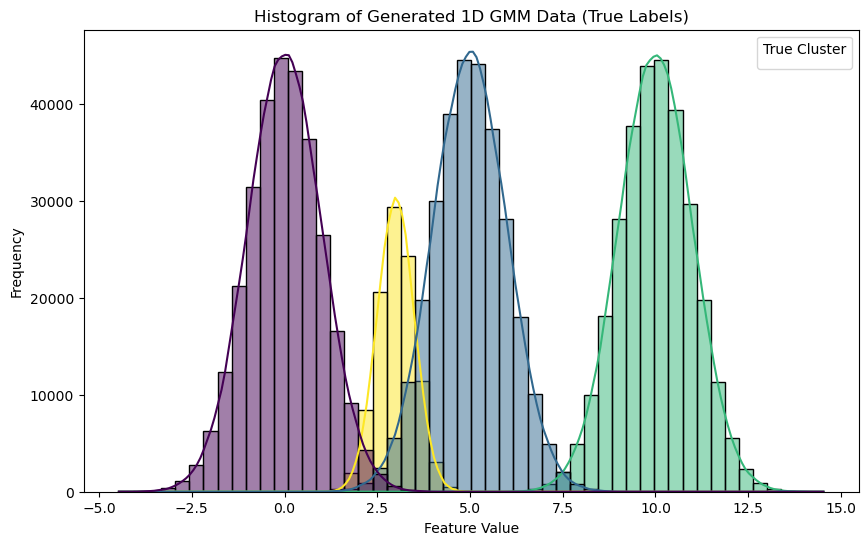

In [22]:
# plot the generated data
# Load the generated data from CSV files
X_df = pd.read_csv('datasets/gmm_data.csv')
labels_df = pd.read_csv('datasets/gmm_labels.csv')

# Combine data and labels for plotting
plot_df = pd.concat([X_df, labels_df], axis=1)

# Plot histogram colored by true labels
plt.figure(figsize=(10, 6))
sns.histplot(data=plot_df, x='feature_0', hue='label', palette='viridis', kde=True, bins=50)
plt.title('Histogram of Generated 1D GMM Data (True Labels)')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.legend(title='True Cluster')
plt.show()

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import random
from numba import njit, prange
# Generate data
def generate_data(n, means, stds, weights, num_mixtures, use_numpy=True):
    random.seed(0)
    if use_numpy:
        np.random.seed(0)
        mixture_idx = np.random.choice(num_mixtures, size=n, p=weights)
        y = np.fromiter((np.random.normal(means[i], stds[i]) for i in mixture_idx), dtype=np.float64)
    else:
        mixture_idx = [random.choices(range(num_mixtures), weights)[0] for _ in range(n)]
        y = [random.gauss(means[i], stds[i]) for i in mixture_idx]
    return y

In [24]:
import time
import math
# from math import pi, sqrt, exp, log
# Define a normal_pdf function
def normal_pdf(x, mean, std_dev):
    """Calculate normal density function for a given x, mean and standard deviation."""
    return (1.0 / (std_dev * ((2*math.pi)**0.5))) * math.exp(-0.5 * ((x - mean) / std_dev)**2)
def e_step_py(data, means, stds, weights, num_mixtures):
    """E-step: compute responsibilities."""
    resp = []
    for i in range(num_mixtures):
        resp.append([weights[i] * normal_pdf(d, means[i], stds[i]) for d in data])
    resp_sum = [sum(r) for r in zip(*resp)]
    resp = [[r / s for r, s in zip(resp[i], resp_sum)] for i in range(num_mixtures)]
    return resp
def m_step_py(data, resp, num_mixtures):
    """M-step: update parameters."""
    means = [sum(r * d for r, d in zip(resp[i], data)) / sum(resp[i]) for i in range(num_mixtures)]
    stds = [math.sqrt(sum(r * (d - means[i]) ** 2 for r, d in zip(resp[i], data)) / sum(resp[i])) for i in
    range(num_mixtures)]
    weights = [sum(r) / len(data) for r in resp]
    return means, stds, weights
def compute_log_likelihood_py(data, means, stds, weights, num_mixtures):
    """Compute the log-likelihood."""
    ll = sum(math.log(sum(weights[i] * normal_pdf(d, means[i], stds[i]) for i in range(num_mixtures))) for d in data)
    return ll
def em_py(data, means, stds, weights, num_mixtures, num_iter=100):
    """EM algorithm."""
    start_time = time.time()
    log_likelihoods = []
    for _ in range(num_iter):
        resp = e_step_py(data, means, stds, weights, num_mixtures)
        means, stds, weights = m_step_py(data, resp, num_mixtures)
        ll = compute_log_likelihood_py(data, means, stds, weights, num_mixtures)
        log_likelihoods.append(ll)
        print("Vanilla Py step", _, "Log-likelihood:", ll)
    end_time = time.time()
    elapsed_time = end_time - start_time
    return means, stds, weights, elapsed_time, log_likelihoods

In [25]:
def normal_pdf(x, mean, std_dev):
    """Calculate normal density function for a given x, mean and standard deviation."""
    return (1.0 / (std_dev * ((2*np.pi)**0.5))) * np.exp(-0.5 * ((x - mean) / std_dev)**2)
def e_step_numpy(data, means, stds, weights, num_mixtures):
    """E-step: compute responsibilities."""
    resp = np.empty((num_mixtures, len(data)))
    for i in range(num_mixtures):
        resp[i, :] = weights[i] * normal_pdf(data, means[i], stds[i])
    resp /= resp.sum(axis=0)
    return resp
def m_step_numpy(data, resp, num_mixtures):
    """M-step: update parameters."""
    means = np.sum(resp * data, axis=1) / np.sum(resp, axis=1)
    stds = np.sqrt(np.sum(resp * (data - means[:, None]) ** 2, axis=1) / np.sum(resp, axis=1))
    weights = np.mean(resp, axis=1)
    return means, stds, weights

In [26]:
def compute_log_likelihood_numpy(data, means, stds, weights, num_mixtures):
    """Compute the log-likelihood."""
    ll = 0
    for i in range(num_mixtures):
        ll += weights[i] * normal_pdf(data, mean=means[i], std_dev=stds[i])
    ll = np.sum(np.log(ll))
    return ll
def em_numpy(data, means, stds, weights, num_mixtures, num_iter=100, print_output=True):
    """EM algorithm."""
    start_time = time.time()
    log_likelihoods = []
    for _ in range(num_iter):
        resp = e_step_numpy(data, means, stds, weights, num_mixtures)
        means, stds, weights = m_step_numpy(data, resp, num_mixtures)
        ll = compute_log_likelihood_numpy(data, means, stds, weights, num_mixtures)
        log_likelihoods.append(ll)
        if print_output:
            print("NumPy step", _, "Log-likelihood:", ll)
    end_time = time.time()
    elapsed_time = end_time - start_time
    return means, stds, weights, elapsed_time, log_likelihoods

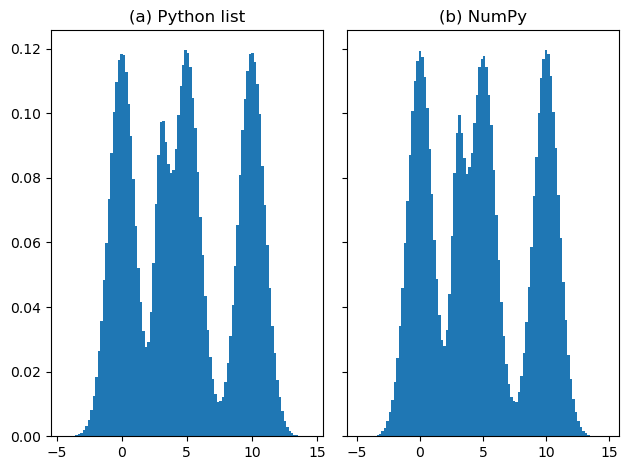

In [37]:
# Set the number of instances with means, stds, and weights to generate
n = 1000000
means = [0, 5, 10, 3]
stds = [1, 1, 1,0.5]
weights = [0.3, 0.3, 0.3, 0.1]
num_mixtures = len(weights)
data = generate_data(n, means, stds, weights, num_mixtures, use_numpy=False)
data_numpy = generate_data(n, means, stds, weights, num_mixtures, use_numpy=True)
data_cupy = cp.asarray(data_numpy) #only enable if you have a CUDA-enabled GPU (and imported `cupy`)
# Create subplots
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout = True)
# Draw the data for Python list
axs[0].hist(data, bins=100, density=True)
axs[0].set_title("(a) Python list")
# Draw the data for numpy
axs[1].hist(data_numpy, bins=100, density=True)
axs[1].set_title("(b) NumPy")
plt.show()

In [28]:
import numpy as np

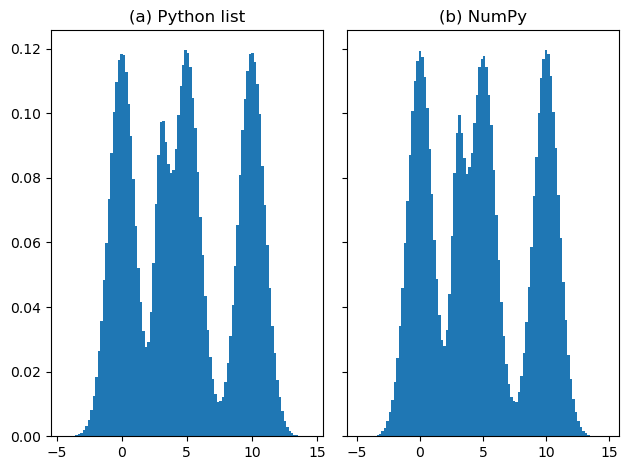

In [29]:
# Set the number of instances with means, stds, and weights to generate
n = 1000000
means = [0, 5, 10, 3]
stds = [1, 1, 1,0.5]
weights = [0.3, 0.3, 0.3, 0.1]
num_mixtures = len(weights)
data = generate_data(n, means, stds, weights, num_mixtures, use_numpy=False)
data_numpy = generate_data(n, means, stds, weights, num_mixtures, use_numpy=True)
# data_cupy = cp.asarray(data_numpy) #only enable if you have a CUDA-enabled GPU (and imported `cupy`)
# Create subplots
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout = True)
# Draw the data for Python list
axs[0].hist(data, bins=100, density=True)
axs[0].set_title("(a) Python list")
# Draw the data for numpy
axs[1].hist(data_numpy, bins=100, density=True)
axs[1].set_title("(b) NumPy")
plt.show()

In [40]:
# Initial parameters
means_init = [-1, -3, 11, 4]
stds_init = [1, 1, 1, 0.5]
parts = len(means_init)
weights_init = [(1/parts)] * parts
num_iter = 1

In [41]:
# Run EM algorithm with vanilla Python
means_py, stds_py, weights_py, elapsed_time_py, log_likelihoods_py = em_py(
data, means_init, stds_init, weights_init, num_mixtures, num_iter)

Vanilla Py step 0 Log-likelihood: -2582154.77915232


In [31]:
# Make the initial means also into NumPy arrays
means_init = np.array(means_init)
stds_init = np.array(stds_init)
weights_init = np.array(weights_init)
# Run EM algorithm with NumPy
means_numpy, stds_numpy, weights_numpy, elapsed_time_numpy, log_likelihoods_numpy = em_numpy(
data_numpy[:100], means_init, stds_init, weights_init, num_mixtures, num_iter,
print_output=False
)
means_numpy, stds_numpy, weights_numpy, elapsed_time_numpy, log_likelihoods_numpy = em_numpy(
data_numpy, means_init, stds_init, weights_init, num_mixtures, num_iter
)

NumPy step 0 Log-likelihood: -2581404.261439712
NumPy step 1 Log-likelihood: -2564104.366757368
NumPy step 2 Log-likelihood: -2556997.094354966
NumPy step 3 Log-likelihood: -2554859.3549245144
NumPy step 4 Log-likelihood: -2554117.8439922445
NumPy step 5 Log-likelihood: -2553769.4140029433
NumPy step 6 Log-likelihood: -2553573.186908773
NumPy step 7 Log-likelihood: -2553452.491059332
NumPy step 8 Log-likelihood: -2553375.025107684
NumPy step 9 Log-likelihood: -2553324.4228862813
NumPy step 10 Log-likelihood: -2553291.180725
NumPy step 11 Log-likelihood: -2553269.242420766
NumPy step 12 Log-likelihood: -2553254.6025180044
NumPy step 13 Log-likelihood: -2553244.618537692
NumPy step 14 Log-likelihood: -2553237.5773788323
NumPy step 15 Log-likelihood: -2553232.388304526
NumPy step 16 Log-likelihood: -2553228.366487335
NumPy step 17 Log-likelihood: -2553225.086215933
NumPy step 18 Log-likelihood: -2553222.284788504
NumPy step 19 Log-likelihood: -2553219.8010872398
NumPy step 20 Log-likeliho

In [32]:
from numba import jit, njit, prange
@jit
def normal_pdf(x, mean, std_dev):
    """Calculate normal density function for a given x, mean and standard deviation."""
    return (1.0 / (std_dev * ((2*np.pi)**0.5))) * np.exp(-0.5 * ((x - mean) / std_dev)**2)
@jit
def compute_resp(data, means, stds, weights, i, j):
    return weights[i] * normal_pdf(data[j], means[i], stds[i])
@jit(parallel=True)
def e_step_numba(data, means, stds, weights, num_mixtures):
    resp = np.empty((num_mixtures, len(data)))
    for i in prange(num_mixtures):
        for j in range(len(data)):
            resp[i, j] = compute_resp(data, means, stds, weights, i, j)
    sum_resp = np.sum(resp, axis=0)
    for i in prange(num_mixtures):
        for j in range(len(data)):
            resp[i, j] /= sum_resp[j]
    return resp
@jit(parallel=True)
def m_step_numba(data, resp, num_mixtures):
    means = np.zeros(num_mixtures)
    stds = np.zeros(num_mixtures)
    weights = np.zeros(num_mixtures)
    for i in prange(num_mixtures):
        resp_sum = np.sum(resp[i, :])
        weighted_sum = np.sum(resp[i, :] * data)
        means[i] = weighted_sum / resp_sum
        stds[i] = np.sqrt(np.sum(resp[i, :] * (data - means[i]) ** 2) / resp_sum)
        weights[i] = resp_sum / resp.shape[1]
    return means, stds, weights
def em_numba(data, means, stds, weights, num_mixtures, num_iter=100, print_output=True):
    start_time = time.time()
    log_likelihoods = []
    for _ in prange(num_iter):
        resp = e_step_numba(data, means, stds, weights, num_mixtures)
        means, stds, weights = m_step_numba(data, resp, num_mixtures)
        ll = compute_log_likelihood_numpy(data, means, stds, weights, num_mixtures)
        log_likelihoods.append(ll)
        if print_output:
            print("Numba step", _, "Log-likelihood:", ll)
    end_time = time.time()
    elapsed_time = end_time - start_time
    return means, stds, weights, elapsed_time, log_likelihoods

In [33]:
# Run EM algorithm with Numba
# Warm-up run
means_numba, stds_numba, weights_numba, elapsed_time_numba, log_likelihoods_numba = em_numba(
data_numpy[:100], means_init, stds_init, weights_init, num_mixtures, num_iter, print_output=False
)
means_numba, stds_numba, weights_numba, elapsed_time_numba, log_likelihoods_numba = em_numba(
data_numpy, means_init, stds_init, weights_init, num_mixtures, num_iter
)

Numba step 0 Log-likelihood: -2581404.261439898
Numba step 1 Log-likelihood: -2564104.366757518
Numba step 2 Log-likelihood: -2556997.0943550174
Numba step 3 Log-likelihood: -2554859.354924579
Numba step 4 Log-likelihood: -2554117.8439923525
Numba step 5 Log-likelihood: -2553769.4140030583
Numba step 6 Log-likelihood: -2553573.186908894
Numba step 7 Log-likelihood: -2553452.491059437
Numba step 8 Log-likelihood: -2553375.025107807
Numba step 9 Log-likelihood: -2553324.4228864317
Numba step 10 Log-likelihood: -2553291.1807251167
Numba step 11 Log-likelihood: -2553269.242420915
Numba step 12 Log-likelihood: -2553254.6025181296
Numba step 13 Log-likelihood: -2553244.618537849
Numba step 14 Log-likelihood: -2553237.577378978
Numba step 15 Log-likelihood: -2553232.388304678
Numba step 16 Log-likelihood: -2553228.3664874556
Numba step 17 Log-likelihood: -2553225.0862160604
Numba step 18 Log-likelihood: -2553222.284788633
Numba step 19 Log-likelihood: -2553219.801087385
Numba step 20 Log-like

In [34]:
import cupy as cp

def normal_pdf_cupy(x, mean, std_dev):
    """Calculate normal density function for a given x, mean and standard deviation."""
    return (1.0 / (std_dev * ((2*cp.pi)**0.5))) * cp.exp(-0.5 * ((x - mean) / std_dev)**2)

def e_step_cupy(data, means, stds, weights, num_mixtures):
    """E-step: compute responsibilities."""
    resp = cp.empty((num_mixtures, len(data)))
    for i in range(num_mixtures):
        resp[i, :] = weights[i] * normal_pdf_cupy(data, means[i], stds[i])
    resp /= resp.sum(axis=0)
    return resp

def m_step_cupy(data, resp, num_mixtures):
    """M-step: update parameters."""
    means = cp.sum(resp * data, axis=1) / cp.sum(resp, axis=1)
    stds = cp.sqrt(cp.sum(resp * (data - means[:, None]) ** 2, axis=1) / cp.sum(resp, axis=1))
    weights = cp.mean(resp, axis=1)
    return means, stds, weights

def compute_log_likelihood_cupy(data, means, stds, weights, num_mixtures):
    """Compute the log-likelihood."""
    ll = 0
    for i in range(num_mixtures):
        ll += weights[i] * normal_pdf_cupy(data, mean=means[i], std_dev=stds[i])
    ll = cp.sum(cp.log(ll))
    return ll

def em_cupy(data, means, stds, weights, num_mixtures, num_iter=100):
    """EM algorithm."""
    start_time = time.time()
    log_likelihoods = []
    for _ in range(num_iter):
        resp = e_step_cupy(data, means, stds, weights, num_mixtures)
        means, stds, weights = m_step_cupy(data, resp, num_mixtures)
        ll = compute_log_likelihood_cupy(data, means, stds, weights, num_mixtures)
        log_likelihoods.append(ll)
        print("CuPy step", _, "Log-likelihood:", ll)
    end_time = time.time()
    elapsed_time = end_time - start_time
    return means, stds, weights, elapsed_time, log_likelihoods

In [38]:
# Run EM algorithm with CuPy (only works with CUDA-enabled GPU)
means_cupy, stds_cupy, weights_cupy, elapsed_time_cupy, log_likelihoods_cupy = em_cupy(
data_cupy, means_init, stds_init, weights_init, num_mixtures, num_iter
)
print("-" * 50)
# Print results
print("Python:\n\tmeans =", means_py, "\n\tstds =", stds_py, "\n\tweights =", weights_py,
"\n\ttime =", elapsed_time_py, "s")
print("NumPy:\n\tmeans =", means_numpy, "\n\tstds =", stds_numpy, "\n\tweights =", weights_numpy,
"\n\ttime =", elapsed_time_numpy, "s")
print("Numba:\n\tmeans =", means_numba, "\n\tstds =", stds_numba, "\n\tweights =", weights_numba,
"\n\ttime =", elapsed_time_numba, "s")
print("CuPy:\n\tmeans =", means_cupy, "\n\tstds =", stds_cupy, "\n\tweights =", weights_cupy,
"\n\ttime =", elapsed_time_cupy, "s")

CuPy step 0 Log-likelihood: -2581404.261439712
CuPy step 1 Log-likelihood: -2564104.36675737
CuPy step 2 Log-likelihood: -2556997.0943549667
CuPy step 3 Log-likelihood: -2554859.3549245163
CuPy step 4 Log-likelihood: -2554117.843992245
CuPy step 5 Log-likelihood: -2553769.4140029433
CuPy step 6 Log-likelihood: -2553573.1869087704
CuPy step 7 Log-likelihood: -2553452.491059334
CuPy step 8 Log-likelihood: -2553375.0251076836
CuPy step 9 Log-likelihood: -2553324.4228862817
CuPy step 10 Log-likelihood: -2553291.1807250003
CuPy step 11 Log-likelihood: -2553269.242420767
CuPy step 12 Log-likelihood: -2553254.602518004
CuPy step 13 Log-likelihood: -2553244.6185376924
CuPy step 14 Log-likelihood: -2553237.5773788313
CuPy step 15 Log-likelihood: -2553232.3883045265
CuPy step 16 Log-likelihood: -2553228.366487335
CuPy step 17 Log-likelihood: -2553225.0862159333
CuPy step 18 Log-likelihood: -2553222.284788503
CuPy step 19 Log-likelihood: -2553219.8010872407
CuPy step 20 Log-likelihood: -2553217.5

NameError: name 'means_py' is not defined

In [42]:
print("-" * 50)
# Print results
print("Python:\n\tmeans =", means_py, "\n\tstds =", stds_py, "\n\tweights =", weights_py,
"\n\ttime =", elapsed_time_py, "s")
print("NumPy:\n\tmeans =", means_numpy, "\n\tstds =", stds_numpy, "\n\tweights =", weights_numpy,
"\n\ttime =", elapsed_time_numpy, "s")
print("Numba:\n\tmeans =", means_numba, "\n\tstds =", stds_numba, "\n\tweights =", weights_numba,
"\n\ttime =", elapsed_time_numba, "s")
print("CuPy:\n\tmeans =", means_cupy, "\n\tstds =", stds_cupy, "\n\tweights =", weights_cupy,
"\n\ttime =", elapsed_time_cupy, "s")

--------------------------------------------------
Python:
	means = [0.13621722607785153, -1.3954741196681824, 9.745176296080173, 4.381296648623432] 
	stds = [0.9568056251711393, 0.7983795264382857, 1.2940168229564424, 1.091418347889751] 
	weights = [0.28585075249067776, 0.0203618739429675, 0.32556941152750385, 0.3682179620386543] 
	time = 1.8870956897735596 s
NumPy:
	means = [ 0.16172899 -0.94626142 10.03067732  4.38978313] 
	stds = [0.77762372 0.78592741 0.97109081 1.43167665] 
	weights = [0.20771826 0.07089598 0.29572718 0.42565858] 
	time = 71.31245350837708 s
Numba:
	means = [ 0.16172899 -0.94626142 10.03067732  4.38978313] 
	stds = [0.77762372 0.78592741 0.97109081 1.43167665] 
	weights = [0.20771826 0.07089598 0.29572718 0.42565858] 
	time = 33.22973561286926 s
CuPy:
	means = [ 0.16172899 -0.94626142 10.03067732  4.38978313] 
	stds = [0.77762372 0.78592741 0.97109081 1.43167665] 
	weights = [0.20771826 0.07089598 0.29572718 0.42565858] 
	time = 23.42483425140381 s


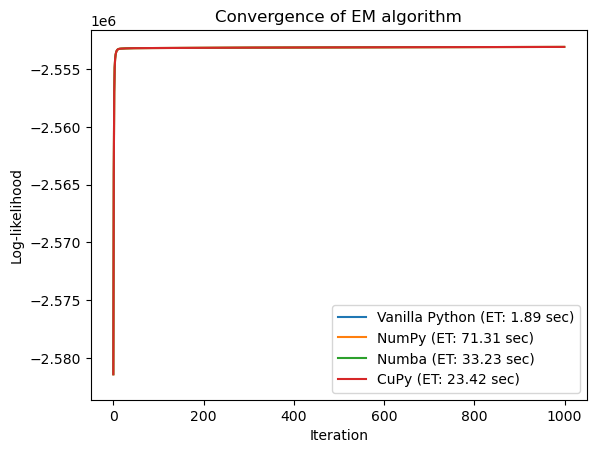

In [43]:
# Plot the convergence
plt.plot(log_likelihoods_py, label=f'Vanilla Python (ET: {elapsed_time_py:.2f} sec)')
plt.plot(log_likelihoods_numpy, label=f'NumPy (ET: {elapsed_time_numpy:.2f} sec)')
plt.plot(log_likelihoods_numba, label=f'Numba (ET: {elapsed_time_numba:.2f} sec)')
log_likelihoods_cupy_np = [item.get() for item in log_likelihoods_cupy]
plt.plot(log_likelihoods_cupy_np, label=f'CuPy (ET: {elapsed_time_cupy:.2f} sec)')
plt.title('Convergence of EM algorithm')
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.legend()
plt.show()

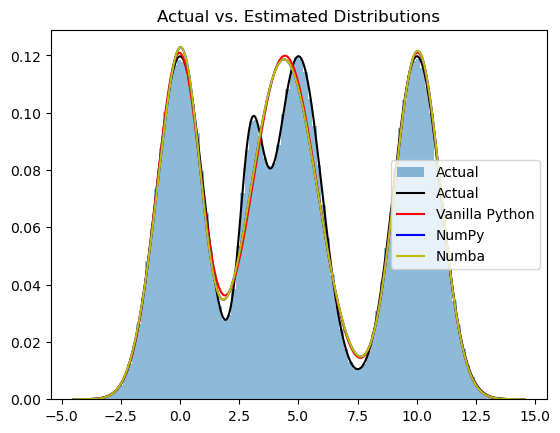

In [72]:
from scipy.stats import norm
# Compute the actual and estimated PDFs
x = np.linspace(min(data), max(data), 1000)
pdf_actual = sum(w * norm.pdf(x, m, s) for m, s, w in zip(means, stds, weights))
pdf_py = sum(w * norm.pdf(x, m, s) for m, s, w in zip(means_py, stds_py, weights_py))
pdf_numpy = sum(w * norm.pdf(x, m, s) for m, s, w in zip(means_numpy, stds_numpy, weights_numpy))
pdf_numba = sum(w * norm.pdf(x, m, s) for m, s, w in zip(means_numba, stds_numba, weights_numba))
# Uncommonet if running also the cupy approach (this ensure the compatibility of the data type)
# means_cupy = cp.asnumpy(means_cupy)
# stds_cupy = cp.asnumpy(stds_cupy)
# weights_cupy = cp.asnumpy(weights_cupy)
# pdf_cupy = sum(w * norm.pdf(x, m, s) for m, s, w in zip(means_cupy, stds_cupy, weights_cupy))
# Plot the actual and estimated PDFs
plt.hist(data, bins=100, density=True, alpha=0.5, label='Actual')
plt.plot(x, pdf_actual, 'k-', label='Actual')
plt.plot(x, pdf_py, 'r-', label='Vanilla Python')
plt.plot(x, pdf_numpy, 'b-', label='NumPy')
plt.plot(x, pdf_numba, 'y-', label='Numba')
# plt.plot(x, pdf_cupy, 'g-', label='CuPy')
plt.title('Actual vs. Estimated Distributions')
plt.legend()
plt.show()

In [73]:
# Add this after your EM algorithm runs

# Save log likelihoods from different implementations to CSV files
def save_log_likelihoods(log_likelihoods, algorithm_name, prefix="gmm"):
    """
    Save log likelihood values per iteration to a CSV file
    
    Parameters:
    -----------
    log_likelihoods : list or array
        List of log likelihood values per iteration
    algorithm_name : str
        Name of the algorithm (e.g., 'numpy', 'numba', 'python')
    prefix : str, default="gmm"
        Prefix for output filename
    """
    import os
    import pandas as pd
    
    # Create directory if it doesn't exist
    os.makedirs('convergence_data', exist_ok=True)
    
    # Convert to DataFrame
    df = pd.DataFrame({
        'iteration': range(len(log_likelihoods)),
        'log_likelihood': log_likelihoods
    })
    
    # Save to CSV
    filename = f'convergence_data/{prefix}_{algorithm_name}_log_likelihoods.csv'
    df.to_csv(filename, index=False)
    print(f"Log likelihoods saved to {filename}")

# Save log likelihoods for each implementation
save_log_likelihoods(log_likelihoods_py, 'python')
save_log_likelihoods(log_likelihoods_numpy, 'numpy')
save_log_likelihoods(log_likelihoods_numba, 'numba')
# Uncomment if using CuPy
save_log_likelihoods([ll.get() for ll in log_likelihoods_cupy], 'cupy')

Log likelihoods saved to convergence_data/gmm_python_log_likelihoods.csv
Log likelihoods saved to convergence_data/gmm_numpy_log_likelihoods.csv
Log likelihoods saved to convergence_data/gmm_numba_log_likelihoods.csv
Log likelihoods saved to convergence_data/gmm_cupy_log_likelihoods.csv


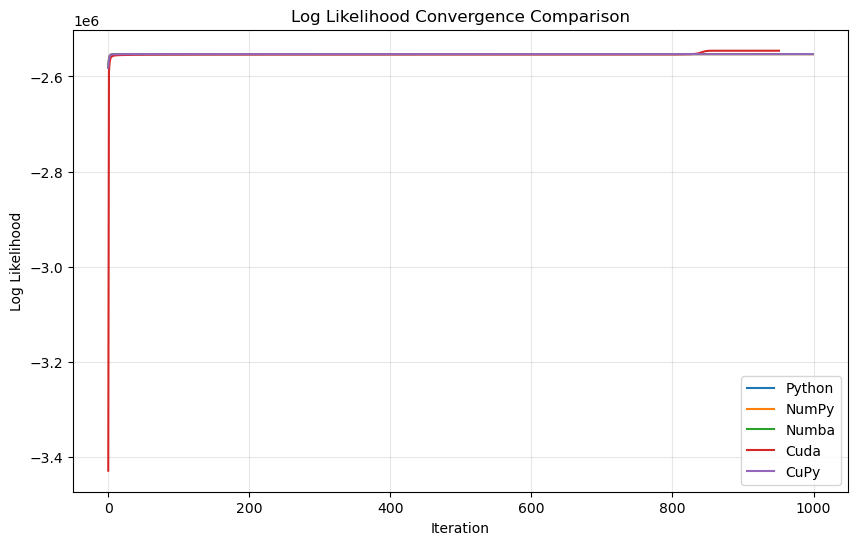

In [44]:
# Code to load and plot log likelihoods from saved files
import pandas as pd
import matplotlib.pyplot as plt

# Load log likelihood data
py_data = pd.read_csv('convergence_data/gmm_python_log_likelihoods.csv')
numpy_data = pd.read_csv('convergence_data/gmm_numpy_log_likelihoods.csv')
numba_data = pd.read_csv('convergence_data/gmm_numba_log_likelihoods.csv')
cpp_data = pd.read_csv('convergence_data/gmm_cuda_log_likelihoods.csv')
cupy_data = pd.read_csv('convergence_data/gmm_cupy_log_likelihoods.csv')  # If using CuPy

# Create plot
plt.figure(figsize=(10, 6))
plt.plot(py_data['iteration'], py_data['log_likelihood'], label='Python')
plt.plot(numpy_data['iteration'], numpy_data['log_likelihood'], label='NumPy')
plt.plot(numba_data['iteration'], numba_data['log_likelihood'], label='Numba')
plt.plot(cpp_data['iteration'], cpp_data['log_likelihood'], label = 'Cuda')
plt.plot(cupy_data['iteration'], cupy_data['log_likelihood'], label='CuPy')  # If using CuPy

plt.title('Log Likelihood Convergence Comparison')
plt.xlabel('Iteration')
plt.ylabel('Log Likelihood')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('convergence_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

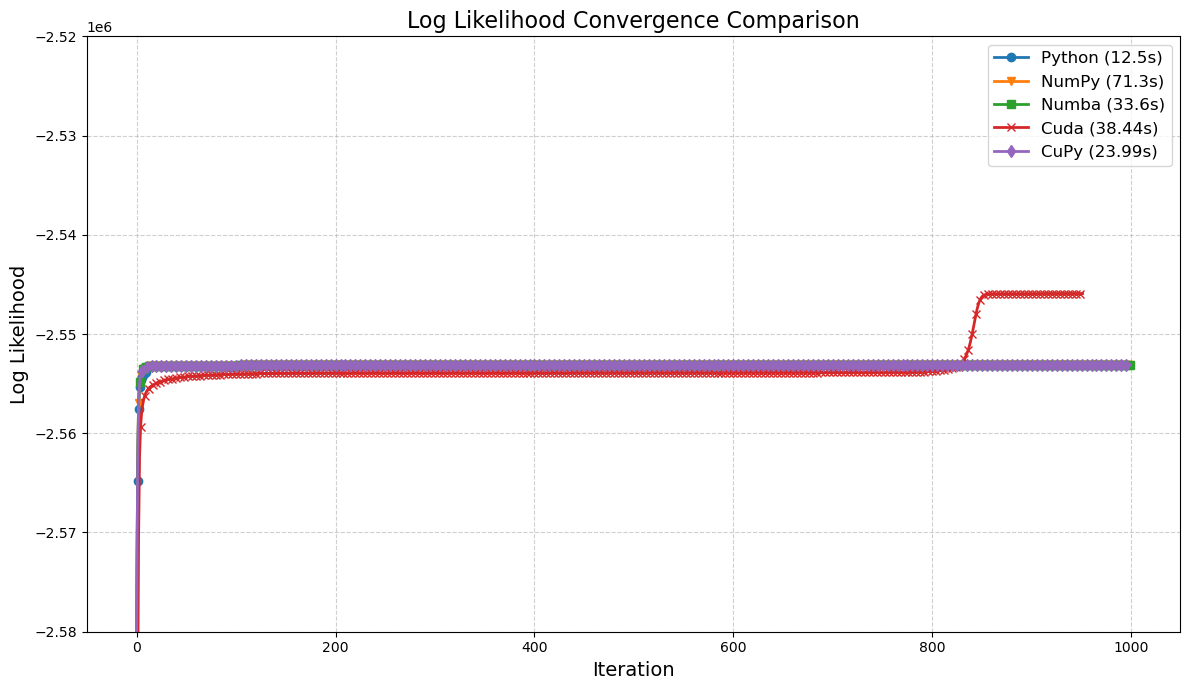

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
py_data = pd.read_csv('convergence_data/gmm_python_log_likelihoods.csv')
numpy_data = pd.read_csv('convergence_data/gmm_numpy_log_likelihoods.csv')
numba_data = pd.read_csv('convergence_data/gmm_numba_log_likelihoods.csv')
cpp_data = pd.read_csv('convergence_data/gmm_cuda_log_likelihoods.csv')
cupy_data = pd.read_csv('convergence_data/gmm_cupy_log_likelihoods.csv')  # If using CuPy

# Assume execution time is stored in a CSV (or hardcode if not available)
# For example, if you have time information separately:
execution_times = {
    'Python': 12.5,   # seconds (put your real numbers here)
    'NumPy': 71.3,
    'Numba': 33.6,
    'Cuda': 38.44,
    'CuPy': 23.99
}

# Plot
plt.figure(figsize=(12, 7))

# Plot each line with a label that includes the execution time
plt.plot(py_data['iteration'], py_data['log_likelihood'],
         label=f"Python ({execution_times['Python']}s)", linewidth=2, marker='o', markevery=1)

plt.plot(numpy_data['iteration'], numpy_data['log_likelihood'],
         label=f"NumPy ({execution_times['NumPy']}s)", linewidth=2, marker='v', markevery=2)

plt.plot(numba_data['iteration'], numba_data['log_likelihood'],
         label=f"Numba ({execution_times['Numba']}s)", linewidth=2, marker='s', markevery=3)

plt.plot(cpp_data['iteration'], cpp_data['log_likelihood'],
         label=f"Cuda ({execution_times['Cuda']}s)", linewidth=2, marker='x', markevery=4)

plt.plot(cupy_data['iteration'], cupy_data['log_likelihood'],
         label=f"CuPy ({execution_times['CuPy']}s)", linewidth=2, marker='d', markevery=5)

plt.title('Log Likelihood Convergence Comparison', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Log Likelihood', fontsize=14)

plt.ylim(-2.58e6, -2.52e6)  # Optional zoom

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('convergence_comparison_with_time.png', dpi=300, bbox_inches='tight')
plt.show()


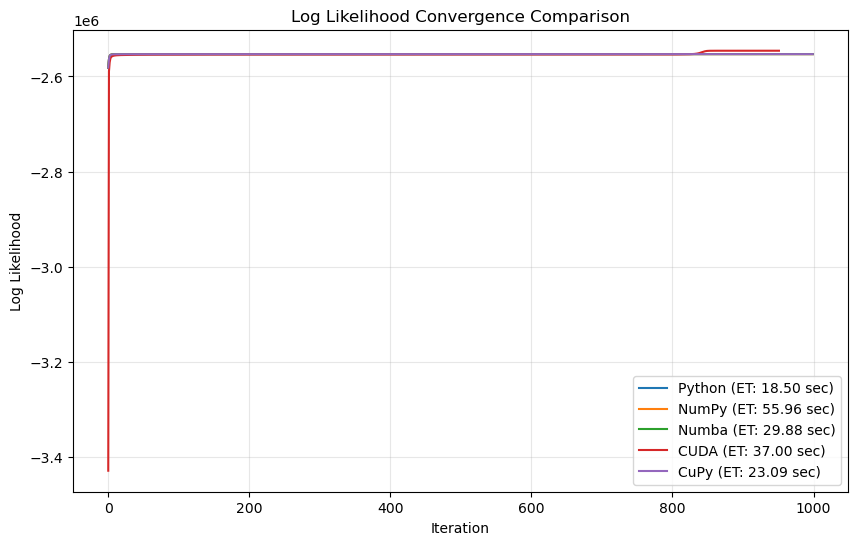

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# Load log likelihood data
py_data = pd.read_csv('convergence_data/gmm_python_log_likelihoods.csv')
numpy_data = pd.read_csv('convergence_data/gmm_numpy_log_likelihoods.csv')
numba_data = pd.read_csv('convergence_data/gmm_numba_log_likelihoods.csv')
cpp_data = pd.read_csv('convergence_data/gmm_cuda_log_likelihoods.csv')

# Define execution times 
# Python implementations (from your prompt)
# elapsed_time_py = 10.45     # Replace with your actual Python time
# elapsed_time_numpy = 1.23   # Replace with your actual NumPy time
# elapsed_time_numba = 0.34   # Replace with your actual Numba time

# CUDA time (from the additional file you mentioned)
elapsed_time_cuda = 37    # Replace with your actual CUDA time


# Create plot
plt.figure(figsize=(10, 6))
plt.plot(py_data['iteration'], py_data['log_likelihood'], 
         label=f'Python (ET: {elapsed_time_py:.2f} sec)')
plt.plot(numpy_data['iteration'], numpy_data['log_likelihood'], 
         label=f'NumPy (ET: {elapsed_time_numpy:.2f} sec)')
plt.plot(numba_data['iteration'], numba_data['log_likelihood'], 
         label=f'Numba (ET: {elapsed_time_numba:.2f} sec)')
plt.plot(cpp_data['iteration'], cpp_data['log_likelihood'], 
         label=f'CUDA (ET: {elapsed_time_cuda:.2f} sec)')
plt.plot(cupy_data['iteration'], cupy_data['log_likelihood'], 
         label=f'CuPy (ET: {elapsed_time_cupy:.2f} sec)')  # If using CuPy

plt.title('Log Likelihood Convergence Comparison')
plt.xlabel('Iteration')
plt.ylabel('Log Likelihood')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('convergence_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

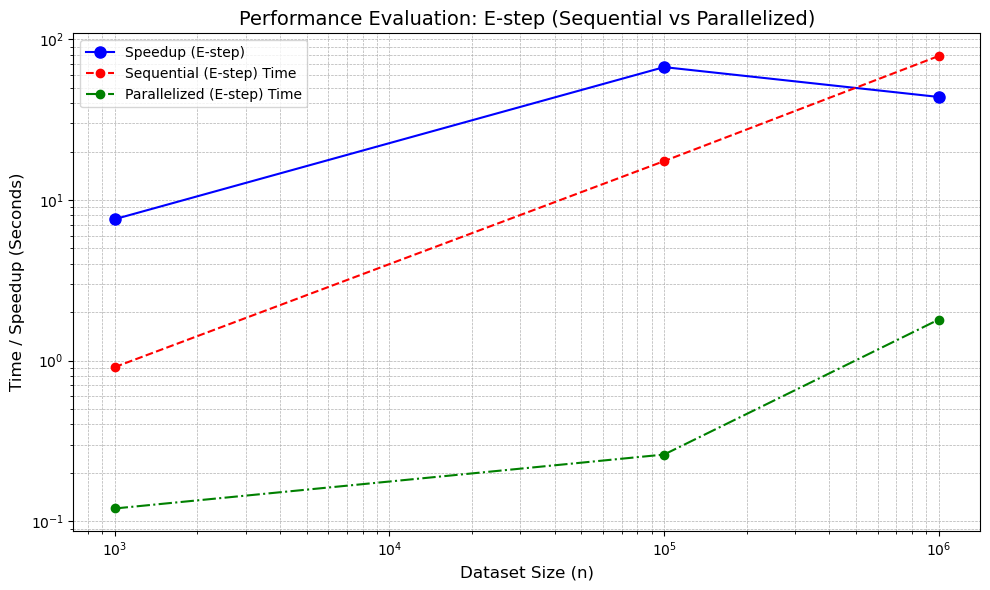

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Data for different dataset sizes (n = 10^3, 10^5, 10^6)
dataset_sizes = [10**3, 10**5, 10**6]

# Sequential execution times for E-step (in seconds)
seq_times = [0.91, 17.43, 78.66]

# Parallelized execution times for E-step (in seconds)
par_times = [0.12, 0.26, 1.80]

# Calculate speedup
speedup = [seq/par for seq, par in zip(seq_times, par_times)]

# Plot Speedup
plt.figure(figsize=(10, 6))

plt.plot(dataset_sizes, speedup, marker='o', label='Speedup (E-step)', color='b', linestyle='-', markersize=8)

# Plot other data
plt.plot(dataset_sizes, seq_times, marker='o', label='Sequential (E-step) Time', color='r', linestyle='--')
plt.plot(dataset_sizes, par_times, marker='o', label='Parallelized (E-step) Time', color='g', linestyle='-.')

# Set labels, title and legend
plt.xlabel("Dataset Size (n)", fontsize=12)
plt.ylabel("Time / Speedup (Seconds)", fontsize=12)
plt.title("Performance Evaluation: E-step (Sequential vs Parallelized)", fontsize=14)
plt.xscale('log')  # Set x-axis to logarithmic scale for better visualization
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)

# Show plot
plt.tight_layout()
plt.show()
